# Tutorial illustrating usage of class piecewise_model_new on different datasets

## Install LIME

In [ ]:
! pip install lime

In [ ]:
import numpy as np
import sklearn
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import random
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
import time
from sklearn.datasets import fetch_california_housing

import lime
import lime.lime_tabular
import warnings
from lime import submodular_pick

In [13]:
import sys
sys.path.append('path_to_PLLI')
# sys.path.append('/Users/kartik/Google Drive/Interpreter_implementation/PLLI')

In [14]:
from piecewise_model import piecewise_model_new

# Illustration on Real and Synthetic Data
## Part 1: Real Data

### Import Boston Data and Fit RF regression to it

In [45]:
boston = load_boston()
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=1000)
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(boston.data, boston.target, train_size=0.80, test_size=0.20)
mean = train.mean(0)
std = train.std(0)
train = (train-mean)/std
test  = (test-mean)/std

rf.fit(train, labels_train);
print("Random Forest R^2 Score: " +str(round(r2_score(rf.predict(test),labels_test),3)))
print('Random Forest MSError', np.mean((rf.predict(test) - labels_test) ** 2))
print('MSError when predicting the mean', np.mean((labels_train.mean() - labels_test) ** 2))

Random Forest R^2 Score: 0.852
Random Forest MSError 8.89016468411759
MSError when predicting the mean 87.61159779486246


### Compute the Black Box RF's predictions on train and test

In [46]:
Y_train   = rf.predict(train)
Y_test    = rf.predict(test)

## Initialize the piecewise model: Equal quantile, K=2, N_clus=2

#### piecewise_model_new class takes the following inputs:
#### Number of Intervals, fit_type, delta (default=1), black_box_model, Num_components in PCA , 
#### Number of regions/clusters to divide an interval into, Project or not ('true'=project), minimum elements in a cluster,
#### Interval division method: "equal_quantile" or "optimal"

In [47]:
K=2
normalize = 0
delta = 1
num_clusters =2
num_components = 2
min_clus = 50
fit_type = 'linear'
model = piecewise_model_new(K, 'linear', delta,  rf,num_components, num_clusters, 'true', min_clus, 'equal_quantile')

### Fit the piecewise model and compute the prediction on test set

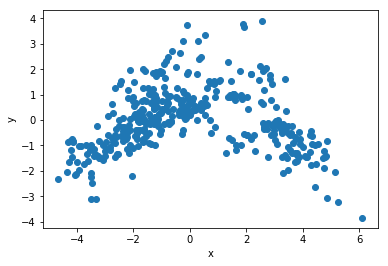

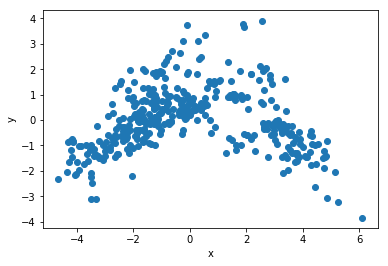

In [48]:
model.fit(train,Y_train)

### Plot: different colors show different regions of the partition

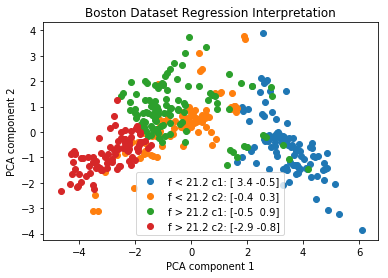

In [49]:
ind_sequence= model.sequence_indices
for i in range(K):
  a = ind_sequence[i]
  b = ind_sequence[i+1]   
  data  = model.Xs_transform[a:b] 
  for j in range(num_clusters):
        index_cluster = np.where(np.array(model.cluster_index[a:b])==j)[0]
        if(i==0):
          name = 'f < '+ str(round(model.sequence_indices_predns[1],1))+ ' c' + str(j+1) + ': ' + str(np.round(model.cluster_centers[i][j],1))
        if(i==1):
          name = 'f > '+ str(round(model.sequence_indices_predns[1],1))+ ' c' + str(j+1)  + ': ' + str(np.round(model.cluster_centers[i][j],1))     
        plt.scatter(data[index_cluster,0], data[index_cluster,1], label= name)
        plt.legend()
        plt.title("Boston Dataset Regression Interpretation")
        plt.xlabel('PCA component 1')
        plt.ylabel('PCA component 2')
        

### Compute the fidelity (MSE b/w prediction of black box and the piecewise model) and MSE with actual labels

In [50]:
predict_test = [0.0]*test.shape[0]
for i in range(test.shape[0]):
    predict_test[i] = model.predict_extension((test[i].reshape(-1,1)).T)

In [51]:
print ("Fidelity of piecewise model " + str(np.mean((np.array(predict_test).T[0]-Y_test)**2)))
print ("Fidelity of constant model " +  str(np.mean((Y_train.mean()-Y_test)**2)))
print ("MSE of piecewise model " + str(np.mean((np.array(predict_test).T[0]-labels_test)**2)))
print ("MSE of constant model "+ str(np.mean((Y_train.mean()-labels_test)**2)))

Fidelity of piecewise model 4.40563800247779
Fidelity of constant model 61.967155440528195
MSE of piecewise model 16.02398214743593
MSE of constant model 87.59878618607824


In [52]:
array = model.model_interpretations_extension()

for i in range(2):
    for j in range(2):
      print ("Risk interval " + str(i+1)) 
      print ("Cluster " + str(j+1))
      print (boston.feature_names[array[0][i,j]])
      print (array[1][i,j])


Risk interval 1
Cluster 1
['DIS' 'INDUS' 'LSTAT' 'NOX' 'PTRATIO' 'TAX' 'AGE' 'B' 'CRIM' 'CHAS' 'RM'
 'ZN' 'RAD']
[3.02681145 2.42629046 2.3874704  1.93016547 1.39430648 1.28251046
 1.09494828 0.4472212  0.39779142 0.17204422 0.15761425 0.
 0.        ]
Risk interval 1
Cluster 2
['RAD' 'NOX' 'LSTAT' 'INDUS' 'CRIM' 'AGE' 'RM' 'DIS' 'B' 'PTRATIO' 'CHAS'
 'ZN' 'TAX']
[2.13217321 1.33330918 1.27663285 0.89324067 0.89246228 0.65663969
 0.55049064 0.48510858 0.48273642 0.43417405 0.38617053 0.07587612
 0.05876962]
Risk interval 2
Cluster 1
['CRIM' 'TAX' 'RM' 'LSTAT' 'DIS' 'RAD' 'PTRATIO' 'NOX' 'B' 'AGE' 'ZN'
 'INDUS' 'CHAS']
[7.71184228 4.40105068 4.02396984 4.00829458 3.88725939 3.75328448
 2.03553414 1.56343891 1.23388099 1.01337818 0.75464176 0.5144506
 0.12279583]
Risk interval 2
Cluster 2
['RM' 'LSTAT' 'DIS' 'TAX' 'PTRATIO' 'B' 'AGE' 'RAD' 'ZN' 'CHAS' 'CRIM'
 'INDUS' 'NOX']
[7.5521076  4.32792997 1.31077897 1.29745598 0.79836726 0.63591385
 0.42801905 0.08335873 0.05909632 0.01192742 0.  

### Initialize Piecewise Model: Equal Quantile, K=4, N_clus=1

In [53]:
K=4
normalize = 0
delta = 1
num_clusters =1
num_components = 2
min_clus = 50
model = piecewise_model_new(K, 'linear', delta,  rf,num_components, num_clusters, 'true', min_clus, 'equal_quantile')

### Fit the piecewise model and compute the prediction on test set

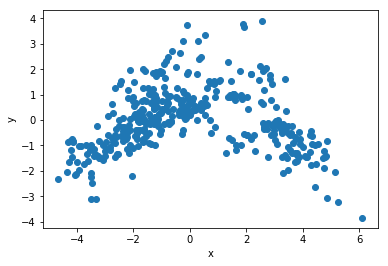

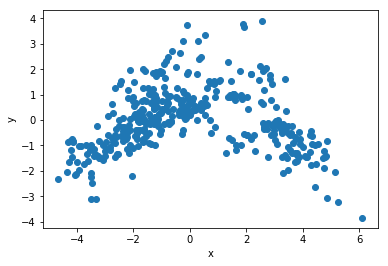

In [54]:
model.fit(train,Y_train)


In [55]:
predict_test = [0.0]*test.shape[0]
for i in range(test.shape[0]):
    predict_test[i] = model.predict_extension((test[i].reshape(-1,1)).T)

### Plot: different colors show different regions of the partition

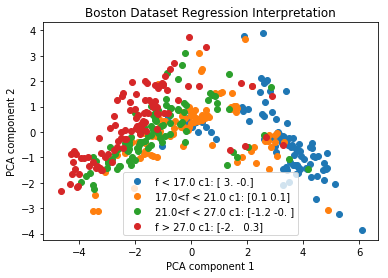

In [56]:
ind_sequence= model.sequence_indices
for i in range(K):
  a = ind_sequence[i]
  b = ind_sequence[i+1]  
  data  = model.Xs_transform[a:b] 
  for j in range(num_clusters):
        index_cluster = np.where(np.array(model.cluster_index[a:b])==j)[0]
        if(i==0):
          name = 'f < '+ str(round(model.sequence_indices_predns[i+1],0))+ ' c' + str(j+1) + ': ' + str(np.round(model.cluster_centers[i],0))
        if(i==1 or i==2):
          name = str(round(model.sequence_indices_predns[i],0))+ '<f < '+ str(round(model.sequence_indices_predns[i+1],0))+ ' c' + str(j+1) + ': ' + str(np.round(model.cluster_centers[i],1))
        if(i==3):
          name = 'f > '+ str(round(model.sequence_indices_predns[i],0))+ ' c' + str(j+1)  + ': ' + str(np.round(model.cluster_centers[i],1))     
          
        plt.scatter(data[index_cluster,0], data[index_cluster,1], label= name)
        plt.legend()
        plt.title("Boston Dataset Regression Interpretation")
        plt.xlabel('PCA component 1')
        plt.ylabel('PCA component 2')
        

### Compute the fidelity (MSE b/w prediction of black box and the piecewise model) and MSE with actual labels

In [57]:
print ("Fidelity of piecewise model " + str(np.mean((np.array(predict_test).T[0]-Y_test)**2)))
print ("Fidelity of constant model " +  str(np.mean((Y_train.mean()-Y_test)**2)))
print ("MSE of piecewise model " + str(np.mean((np.array(predict_test).T[0]-labels_test)**2)))
print ("MSE of constant model "+ str(np.mean((Y_train.mean()-labels_test)**2)))

Fidelity of piecewise model 2.2130572247318194
Fidelity of constant model 61.967155440528195
MSE of piecewise model 13.995587738598129
MSE of constant model 87.59878618607824


### Initialize Piecewise Model: Optimal, K=4, N_clus=1

In [58]:
K=4
normalize = 0
delta = 1
num_clusters =1
num_components = 2
min_clus = 50
model = piecewise_model_new(K, 'linear', delta,  rf,num_components, num_clusters, 'true', min_clus, 'optimal')

### Fit the piecewise model and compute the prediction on test set

In [ ]:
model.fit(train,Y_train)

In [60]:
predict_test = [0.0]*test.shape[0]
for i in range(test.shape[0]):
    predict_test[i] = model.predict_extension((test[i].reshape(-1,1)).T)

### Plot: different colors show different regions of the partition

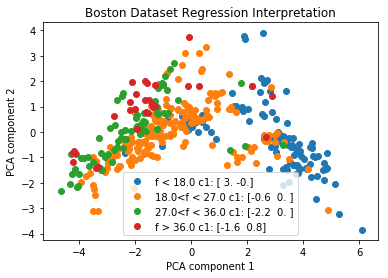

In [62]:
ind_sequence= model.sequence_indices
for i in range(K):
  a = ind_sequence[i]
  b = ind_sequence[i+1]  
  data  = model.Xs_transform[a:b] 
  for j in range(num_clusters):
        index_cluster = np.where(np.array(model.cluster_index[a:b])==j)[0]
        if(i==0):
          name = 'f < '+ str(round(model.sequence_indices_predns[i+1],0))+ ' c' + str(j+1) + ': ' + str(np.round(model.cluster_centers[i],0))
        if(i==1 or i==2):
          name = str(round(model.sequence_indices_predns[i],0))+ '<f < '+ str(round(model.sequence_indices_predns[i+1],0))+ ' c' + str(j+1) + ': ' + str(np.round(model.cluster_centers[i],1))
        if(i==3):
          name = 'f > '+ str(round(model.sequence_indices_predns[i],0))+ ' c' + str(j+1)  + ': ' + str(np.round(model.cluster_centers[i],1))     
          
        plt.scatter(data[index_cluster,0], data[index_cluster,1], label= name)
        plt.legend()
        plt.title("Boston Dataset Regression Interpretation")
        plt.xlabel('PCA component 1')
        plt.ylabel('PCA component 2')
        


In [63]:
array = model.model_interpretations_extension()

for i in range(4):
    for j in range(1):
      print ("Risk interval " + str(i+1)) 
      print ("Cluster " + str(j+1))
      print (boston.feature_names[array[0][i,j]])
      print (array[1][i,j])

Risk interval 1
Cluster 1
['TAX' 'LSTAT' 'NOX' 'INDUS' 'RAD' 'PTRATIO' 'AGE' 'CRIM' 'CHAS' 'RM' 'B'
 'DIS' 'ZN']
[2.10094473 1.66374775 1.3950555  1.26620135 1.24912388 1.09767005
 0.91270111 0.48748205 0.26456505 0.16427389 0.14520584 0.09161045
 0.        ]
Risk interval 2
Cluster 1
['LSTAT' 'RM' 'RAD' 'TAX' 'DIS' 'CRIM' 'B' 'PTRATIO' 'AGE' 'NOX' 'CHAS'
 'ZN' 'INDUS']
[1.67189729 1.53038238 1.11772538 0.93798669 0.66928687 0.6547475
 0.57283608 0.56137545 0.5040749  0.33476677 0.32030801 0.26581292
 0.20587121]
Risk interval 3
Cluster 1
['CRIM' 'RM' 'LSTAT' 'TAX' 'INDUS' 'B' 'PTRATIO' 'AGE' 'DIS' 'CHAS' 'ZN'
 'NOX' 'RAD']
[8.20589723 3.18765939 2.90295514 1.60142884 1.24171397 1.0618087
 0.85941097 0.66999692 0.49699947 0.12186384 0.02089307 0.
 0.        ]
Risk interval 4
Cluster 1
['RAD' 'PTRATIO' 'RM' 'NOX' 'DIS' 'LSTAT' 'AGE' 'TAX' 'INDUS' 'CRIM' 'ZN'
 'CHAS' 'B']
[5.54857124e+00 2.89791167e+00 2.52282394e+00 2.09153234e+00
 2.07716216e+00 1.94179046e+00 1.34191757e+00 1.07763118

In [0]:
boston = load_boston()
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

### Compute the fidelity (MSE b/w prediction of black box and the piecewise model) and MSE with actual labels




In [64]:
print ("Fidelity of piecewise model " + str(np.mean((np.array(predict_test).T[0]-Y_test)**2)))
print ("Fidelity of constant model " +  str(np.mean((Y_train.mean()-Y_test)**2)))
print ("MSE of piecewise model " + str(np.mean((np.array(predict_test).T[0]-labels_test)**2)))
print ("MSE of constant model "+ str(np.mean((Y_train.mean()-labels_test)**2)))

Fidelity of piecewise model 2.5063687720047243
Fidelity of constant model 61.967155440528195
MSE of piecewise model 10.21642442858606
MSE of constant model 87.59878618607824


### Initialize Piecewise Model: Optimal, K=1, N_clus=4

In [65]:
K=1
normalize = 0
delta = 1
num_clusters =4
num_components = 2
min_clus = 50
model = piecewise_model_new(K, 'linear', delta,  rf,num_components, num_clusters, 'true', min_clus, 'equal_quantile')

### Fit the piecewise model and compute the prediction on test set

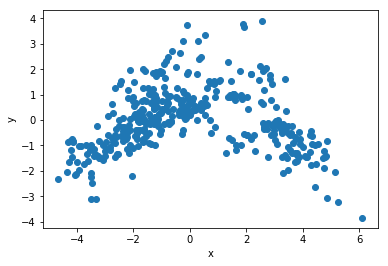

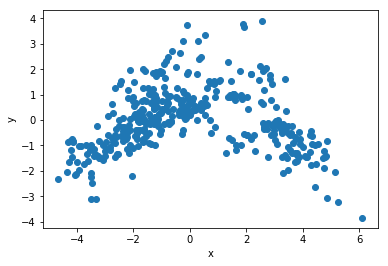

In [66]:
model.fit(train,Y_train)

In [67]:
predict_test = [0.0]*test.shape[0]
for i in range(test.shape[0]):
    predict_test[i] = model.predict_extension((test[i].reshape(-1,1)).T)

### Plot: different colors show different regions of the partition

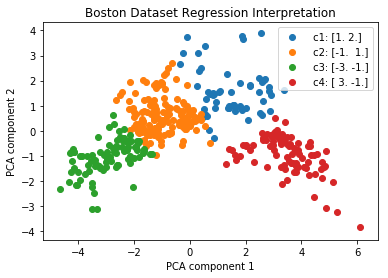

In [68]:
ind_sequence= model.sequence_indices
for i in range(1):
  a = ind_sequence[i]
  b = ind_sequence[i+1]  
  data  = model.Xs_transform[a:b] 
  for j in range(4):
        index_cluster = np.where(np.array(model.cluster_index[a:b])==j)[0]
        if(i==0):
          name = ' c' + str(j+1) + ': ' + str(np.round(model.cluster_centers[i][j],0))

        plt.scatter(data[index_cluster,0], data[index_cluster,1], label= name)

        plt.legend()
        plt.title("Boston Dataset Regression Interpretation")
        plt.xlabel('PCA component 1')
        plt.ylabel('PCA component 2')
        

### Compute the fidelity (MSE b/w prediction of black box and the piecewise model) and MSE with actual labels



In [69]:
print ("Fidelity of piecewise model " + str(np.mean((np.array(predict_test).T[0]-Y_test)**2)))
print ("Fidelity of constant model " +  str(np.mean((Y_train.mean()-Y_test)**2)))
print ("MSE of piecewise model " + str(np.mean((np.array(predict_test).T[0]-labels_test)**2)))
print ("MSE of constant model "+ str(np.mean((Y_train.mean()-labels_test)**2)))

Fidelity of piecewise model 6.698672186922626
Fidelity of constant model 61.967155440528195
MSE of piecewise model 20.29626497730421
MSE of constant model 87.59878618607824


### Initialize Piecewise Model: Optimal, K=2, N_clus=2

In [70]:
K=2
normalize = 0
delta = 1
num_clusters =2
num_components = 2
min_clus = 50
model = piecewise_model_new(K, 'linear', delta,  rf,num_components, num_clusters, 'true', min_clus, 'optimal')

### Fit the piecewise model and compute the prediction on test set

In [ ]:
model.fit(train,Y_train)

In [72]:
predict_test = [0.0]*test.shape[0]
for i in range(test.shape[0]):
    predict_test[i] = model.predict_extension((test[i].reshape(-1,1)).T)

### Plot: different colors show different regions of the partition

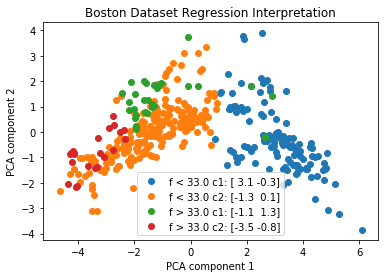

In [73]:
ind_sequence= model.sequence_indices
for i in range(K):
  a = ind_sequence[i]
  b = ind_sequence[i+1]  
  data  = model.Xs_transform[a:b] 
  for j in range(num_clusters):
        index_cluster = np.where(np.array(model.cluster_index[a:b])==j)[0]
        if(i==0):
          name = 'f < '+ str(round(model.sequence_indices_predns[1],1))+ ' c' + str(j+1) + ': ' + str(np.round(model.cluster_centers[i][j],1))
        if(i==1):
          name = 'f > '+ str(round(model.sequence_indices_predns[1],1))+ ' c' + str(j+1)  + ': ' + str(np.round(model.cluster_centers[i][j],1))     

        plt.scatter(data[index_cluster,0], data[index_cluster,1], label= name)

        plt.legend()
        plt.title("Boston Dataset Regression Interpretation")
        plt.xlabel('PCA component 1')
        plt.ylabel('PCA component 2')


### Compute the fidelity (MSE b/w prediction of black box and the piecewise model) and MSE with actual labels

In [74]:
print ("Fidelity of piecewise model " + str(np.mean((np.array(predict_test).T[0]-Y_test)**2)))
print ("Fidelity of constant model " +  str(np.mean((Y_train.mean()-Y_test)**2)))
print ("MSE of piecewise model " + str(np.mean((np.array(predict_test).T[0]-labels_test)**2)))
print ("MSE of constant model "+ str(np.mean((Y_train.mean()-labels_test)**2)))

Fidelity of piecewise model 4.440395061198777
Fidelity of constant model 61.967155440528195
MSE of piecewise model 12.446482767787417
MSE of constant model 87.59878618607824


### Compute the model interpretations

In [0]:
array = model.model_interpretations_extension()
print (array)

In [75]:
array = model.model_interpretations_extension()

for i in range(2):
    for j in range(2):
      print ("Risk interval " + str(i+1)) 
      print ("Cluster " + str(j+1))
      print (boston.feature_names[array[0][i,j]])
      print (array[1][i,j])


Risk interval 1
Cluster 1
['LSTAT' 'NOX' 'PTRATIO' 'TAX' 'RAD' 'AGE' 'INDUS' 'CRIM' 'B' 'CHAS' 'RM'
 'ZN' 'DIS']
[3.30009627 2.43132251 1.86186009 1.40108579 1.05991463 0.91407522
 0.87092839 0.61628642 0.52505575 0.43323393 0.17250263 0.
 0.        ]
Risk interval 1
Cluster 2
['RM' 'RAD' 'TAX' 'DIS' 'AGE' 'LSTAT' 'PTRATIO' 'ZN' 'NOX' 'CHAS' 'INDUS'
 'B' 'CRIM']
[3.96772431 1.69473656 1.65813528 1.19724799 1.02852144 0.99873377
 0.97953289 0.51440232 0.37033572 0.34514784 0.08184536 0.04206847
 0.        ]
Risk interval 2
Cluster 1
['LSTAT' 'B' 'DIS' 'RM' 'NOX' 'AGE' 'RAD' 'TAX' 'ZN' 'PTRATIO' 'INDUS'
 'CHAS' 'CRIM']
[7.56655325 5.32715195 4.75460331 3.67897003 3.13324549 2.75631158
 2.08276898 1.73566425 1.04626523 0.70982865 0.42486005 0.10691232
 0.        ]
Risk interval 2
Cluster 2
['RM' 'B' 'LSTAT' 'INDUS' 'DIS' 'NOX' 'RAD' 'PTRATIO' 'ZN' 'AGE' 'CRIM'
 'CHAS' 'TAX']
[8.29853116 6.9197981  5.15528481 3.61756082 3.26581299 2.85160114
 1.63056664 0.16402708 0.14530849 0.09149638 0. 

### Compute Linear Model and its MSE and Fidelity

In [76]:
model_linear = linear_model.LinearRegression(fit_intercept=True) 
model_linear.fit(train, Y_train)
print("Linear model R^2 Score: " +str(round(r2_score(model_linear.predict(test),Y_test),3)))
print ("Fidelity of the linear model is : " + str(np.mean((model_linear.predict(test)-Y_test)**2)))
print("Linear model R^2 Score: " +str(round(r2_score(model_linear.predict(test),labels_test),3)))
print ("MSE of linear model is : " + str(np.mean((model_linear.predict(test)-labels_test)**2)))

Linear model R^2 Score: 0.722
Fidelity of the linear model is : 13.303029448872692
Linear model R^2 Score: 0.423
MSE of linear model is : 27.653904822900326


In [77]:
model_linear = linear_model.LinearRegression(fit_intercept=True) 
model_linear.fit(train, labels_train)
print("Linear model R^2 Score: " +str(round(r2_score(model_linear.predict(test),Y_test),3)))
print ("Fidelity of the linear model is : " + str(np.mean((model_linear.predict(test)-Y_test)**2)))
print("Linear model R^2 Score: " +str(round(r2_score(model_linear.predict(test),labels_test),3)))
print ("MSE of linear model is : " + str(np.mean((model_linear.predict(test)-labels_test)**2)))

Linear model R^2 Score: 0.725
Fidelity of the linear model is : 13.82164416227745
Linear model R^2 Score: 0.467
MSE of linear model is : 26.800996521003086


### Compute the Regression Tree based model and its MSE and Fidelity

In [78]:
model_tree = tree.DecisionTreeRegressor(max_leaf_nodes=4)
model_tree = model_tree.fit(train, Y_train)
print("Tree model  R^2 Score: " +str(round(r2_score(model_tree.predict(test),Y_test),3)))
print ("Fidelity of the regression tree model is : " + str(np.mean((model_tree.predict(test)-Y_test)**2)))
print("Tree model R^2 Score: " +str(round(r2_score(model_tree.predict(test),labels_test),3)))
print ("MSE of regression tree model is : " + str(np.mean((model_tree.predict(test)-labels_test)**2)))

Tree model  R^2 Score: 0.752
Fidelity of the regression tree model is : 12.12624689118452
Tree model R^2 Score: 0.368
MSE of regression tree model is : 30.905225528300047


In [79]:
model_tree = tree.DecisionTreeRegressor(max_leaf_nodes=4)
model_tree = model_tree.fit(train, labels_train)
print("Tree model  R^2 Score: " +str(round(r2_score(model_tree.predict(test),Y_test),3)))
print ("Fidelity of the regression tree model is : " + str(np.mean((model_tree.predict(test)-Y_test)**2)))
print("Tree model R^2 Score: " +str(round(r2_score(model_tree.predict(test),labels_test),3)))
print ("MSE of regression tree model is : " + str(np.mean((model_tree.predict(test)-labels_test)**2)))

Tree model  R^2 Score: 0.753
Fidelity of the regression tree model is : 12.175826518785355
Tree model R^2 Score: 0.372
MSE of regression tree model is : 30.95476007595661


## Part 2

## **Synthetic Data Example**

### Function to generate non-linear example

In [80]:
def non_linear_example(x):
  return x[0]**2 + x[1]**2 +2*x[1]*x[0]

### Generate data using non_linear_example function

In [81]:
mean = np.zeros(2)
cov = np.eye(2)
data= np.random.multivariate_normal(mean, cov, 1000)
target = np.zeros(1000)

for i in range(data.shape[0]):
  target[i] = non_linear_example(data[i])

## Fit a RF regression to the synthetic data

In [82]:

rf = sklearn.ensemble.RandomForestRegressor(n_estimators=1000)
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(data, target, train_size=0.80, test_size=0.20)

rf.fit(train, labels_train);
print("Random Forest R^2 Score: " +str(round(r2_score(rf.predict(test),labels_test),3)))
print('Random Forest MSError', np.mean((rf.predict(test) - labels_test) ** 2))
print('MSError when predicting the mean', np.mean((labels_train.mean() - labels_test) ** 2))

Random Forest R^2 Score: 0.95
Random Forest MSError 0.40500766288478063
MSError when predicting the mean 10.68653569974498


## Prediction based on RF model 

In [83]:
Y_train  = rf.predict(train)
Y_test   = rf.predict(test)

## Initialize piecewise model: Equal Quantile, K=2, N_clus=2

In [84]:
K=2
normalize = 0
delta = 1
num_clusters =2
num_components = 2
min_clus = 50
model = piecewise_model_new(K, 'linear', delta,  rf,num_components, num_clusters, 'false', min_clus, 'equal_quantile')

## Fit a piecewise model

In [85]:
model.fit(train,Y_train)

In [86]:
predict_test = [0.0]*test.shape[0]
for i in range(test.shape[0]):
    predict_test[i] = model.predict_extension((test[i].reshape(-1,1)).T)

## Piecewise model (Fidelity and MSE)


In [87]:
print ("Fidelity of piecewise model " + str(np.mean((np.array(predict_test).T[0]-Y_test)**2)))
print ("Fidelity of constant model " +  str(np.mean((Y_train.mean()-Y_test)**2)))
print ("MSE of piecewise model " + str(np.mean((np.array(predict_test).T[0]-labels_test)**2)))
print ("MSE of constant model "+ str(np.mean((Y_train.mean()-labels_test)**2)))

Fidelity of piecewise model 0.2918893453221372
Fidelity of constant model 8.203506004303662
MSE of piecewise model 0.36018179601134775
MSE of constant model 10.723417127292285


In [88]:
model.compute_cluster_centers()

({(0, 0): array([-0.5727186 ,  0.51054731]),
  (0, 1): array([ 0.50992261, -0.49957748]),
  (1, 0): array([-0.79388593, -0.97276091]),
  (1, 1): array([0.77113775, 0.98632879])},
 {(0, 0): 24, (0, 1): 10, (1, 0): 633, (1, 1): 631})

### Plot: different colors show different regions of the partition

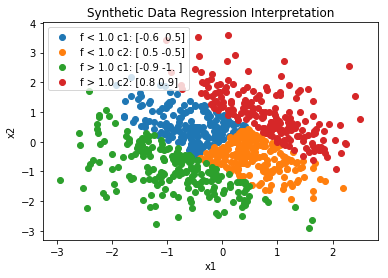

In [89]:
ind_sequence= model.sequence_indices
for i in range(K):
  a = ind_sequence[i]
  b = ind_sequence[i+1]  
  data  = model.Xs_transform[a:b] 
  for j in range(num_clusters):
        index_cluster = np.where(np.array(model.cluster_index[a:b])==j)[0]
        if(i==0):
          name = 'f < '+ str(round(model.sequence_indices_predns[1],1))+ ' c' + str(j+1) + ': ' + str(np.round(model.cluster_centers[i][j],1))
        if(i==1):
          name = 'f > '+ str(round(model.sequence_indices_predns[1],1))+ ' c' + str(j+1)  + ': ' + str(np.round(model.cluster_centers[i][j],1))     
        plt.scatter(data[index_cluster,0], data[index_cluster,1], label= name)
        plt.legend()
        plt.title("Synthetic Data Regression Interpretation")
        plt.xlabel('x1')
        plt.ylabel('x2')        

## Initialize piecewise model: Equal Quantile, K=4, N_clus=1

In [90]:
K=4
normalize = 0
delta = 1
num_clusters =1
num_components = 2
min_clus = 50
model = piecewise_model_new(K, 'linear', delta,  rf,num_components, num_clusters, 'false', min_clus, 'equal_quantile')

## Fit a piecewise model

In [91]:
model.fit(train,Y_train)

In [92]:
predict_test = [0.0]*test.shape[0]
for i in range(test.shape[0]):
    predict_test[i] = model.predict_extension((test[i].reshape(-1,1)).T)

## Piecewise model (Fidelity and MSE)

In [93]:
print ("Fidelity of piecewise model " + str(np.mean((np.array(predict_test).T[0]-Y_test)**2)))
print ("Fidelity of constant model " +  str(np.mean((Y_train.mean()-Y_test)**2)))
print ("MSE of piecewise model " + str(np.mean((np.array(predict_test).T[0]-labels_test)**2)))
print ("MSE of constant model "+ str(np.mean((Y_train.mean()-labels_test)**2)))

Fidelity of piecewise model 2.700945668942863
Fidelity of constant model 8.203506004303662
MSE of piecewise model 4.388245601080302
MSE of constant model 10.723417127292285


### Plot: different colors show different regions of the partition

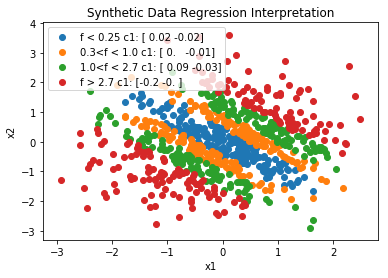

In [94]:
ind_sequence= model.sequence_indices
for i in range(K):
  a = ind_sequence[i]
  b = ind_sequence[i+1]  
  data  = model.Xs_transform[a:b] 
  for j in range(num_clusters):
        index_cluster = np.where(np.array(model.cluster_index[a:b])==j)[0]
        if(i==0):
          name = 'f < '+ str(round(model.sequence_indices_predns[i+1],2))+ ' c' + str(j+1) + ': ' + str(np.round(model.cluster_centers[i],2))
        if(i==1 or i==2):
          name = str(round(model.sequence_indices_predns[i],1))+ '<f < '+ str(round(model.sequence_indices_predns[i+1],1))+ ' c' + str(j+1) + ': ' + str(np.round(model.cluster_centers[i],2))
        if(i==3):
          name = 'f > '+ str(round(model.sequence_indices_predns[i],1))+ ' c' + str(j+1)  + ': ' + str(np.round(model.cluster_centers[i],1))     
          
        plt.scatter(data[index_cluster,0], data[index_cluster,1], label= name)
        plt.legend()
        plt.title("Synthetic Data Regression Interpretation")
        plt.xlabel('x1')
        plt.ylabel('x2')
        


## Initialize piecewise model: Optimal, K=4, N_clus=1

In [95]:
K=4
normalize = 0
delta = 1
num_clusters =1
num_components = 2
min_clus = 50
# model = piecewise_model_extension(K, 'linear', delta,  rf,num_components, num_clusters, 'true', min_clus)
model = piecewise_model_new(K, 'linear', delta,  rf,num_components, num_clusters, 'false', min_clus, 'optimal')

## Fit a piecewise model

In [ ]:
model.fit(train,Y_train)

In [97]:
predict_test = [0.0]*test.shape[0]
for i in range(test.shape[0]):
    predict_test[i] = model.predict_extension((test[i].reshape(-1,1)).T)

## Piecewise model (Fidelity and MSE)

In [98]:
print ("Fidelity of piecewise model " + str(np.mean((np.array(predict_test).T[0]-Y_test)**2)))
print ("Fidelity of constant model " +  str(np.mean((Y_train.mean()-Y_test)**2)))
print ("MSE of piecewise model " + str(np.mean((np.array(predict_test).T[0]-labels_test)**2)))
print ("MSE of constant model "+ str(np.mean((Y_train.mean()-labels_test)**2)))


Fidelity of piecewise model 0.7942510229279232
Fidelity of constant model 8.203506004303662
MSE of piecewise model 1.3307467121853889
MSE of constant model 10.723417127292285


### Plot: different colors show different regions of the partition

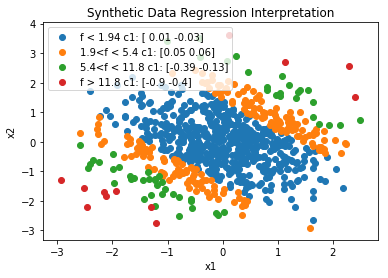

In [99]:
ind_sequence= model.sequence_indices
for i in range(K):
  a = ind_sequence[i]
  b = ind_sequence[i+1]  
  data  = model.Xs_transform[a:b] 
  for j in range(num_clusters):
        index_cluster = np.where(np.array(model.cluster_index[a:b])==j)[0]
        if(i==0):
          name = 'f < '+ str(round(model.sequence_indices_predns[i+1],2))+ ' c' + str(j+1) + ': ' + str(np.round(model.cluster_centers[i],2))
        if(i==1 or i==2):
          name = str(round(model.sequence_indices_predns[i],1))+ '<f < '+ str(round(model.sequence_indices_predns[i+1],1))+ ' c' + str(j+1) + ': ' + str(np.round(model.cluster_centers[i],2))
        if(i==3):
          name = 'f > '+ str(round(model.sequence_indices_predns[i],1))+ ' c' + str(j+1)  + ': ' + str(np.round(model.cluster_centers[i],1))     

        plt.scatter(data[index_cluster,0], data[index_cluster,1], label= name)
        plt.legend()
        plt.title("Synthetic Data Regression Interpretation")
        plt.xlabel('x1')
        plt.ylabel('x2')
        

## Initialize piecewise model: Optimal, K=2, N_clus=2

In [100]:
K=2
normalize = 0
delta = 1
num_clusters =2
num_components = 2
min_clus = 50
model = piecewise_model_new(K, 'linear', delta,  rf,num_components, num_clusters, 'false', min_clus, 'optimal')

## Fit a piecewise model

In [ ]:
model.fit(train,Y_train)

In [102]:
predict_test = [0.0]*test.shape[0]
for i in range(test.shape[0]):
    predict_test[i] = model.predict_extension((test[i].reshape(-1,1)).T)

## Piecewise model (Fidelity and MSE)

In [103]:
print ("Fidelity of piecewise model " + str(np.mean((np.array(predict_test).T[0]-Y_test)**2)))
print ("Fidelity of constant model " +  str(np.mean((Y_train.mean()-Y_test)**2)))
print ("MSE of piecewise model " + str(np.mean((np.array(predict_test).T[0]-labels_test)**2)))
print ("MSE of constant model "+ str(np.mean((Y_train.mean()-labels_test)**2)))

Fidelity of piecewise model 0.2995372981703287
Fidelity of constant model 8.203506004303662
MSE of piecewise model 0.3226782175824499
MSE of constant model 10.723417127292285


### Plot: different colors show different regions of the partition

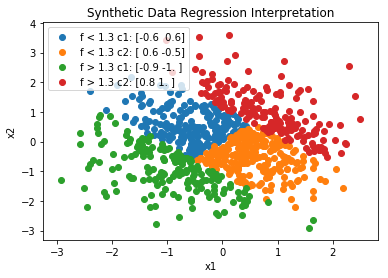

In [104]:
ind_sequence= model.sequence_indices
for i in range(K):
  a = ind_sequence[i]
  b = ind_sequence[i+1]  
  data  = model.Xs_transform[a:b] 
  for j in range(num_clusters):
        index_cluster = np.where(np.array(model.cluster_index[a:b])==j)[0]
        if(i==0):
          name = 'f < '+ str(round(model.sequence_indices_predns[1],1))+ ' c' + str(j+1) + ': ' + str(np.round(model.cluster_centers[i][j],1))
        if(i==1):
          name = 'f > '+ str(round(model.sequence_indices_predns[1],1))+ ' c' + str(j+1)  + ': ' + str(np.round(model.cluster_centers[i][j],1))     
        plt.scatter(data[index_cluster,0], data[index_cluster,1], label= name)
        plt.legend()
        plt.title("Synthetic Data Regression Interpretation")
        plt.xlabel('x1')
        plt.ylabel('x2')


## Initialize piecewise model: Optimal, K=1, N_clus=4

In [105]:
K=1
normalize = 0
delta = 1
num_clusters =4
num_components = 2
min_clus = 50
model = piecewise_model_new(K, 'linear', delta,  rf,num_components, num_clusters, 'false', min_clus, 'optimal')

## Fit a piecewise model

In [106]:
model.fit(train,Y_train)

In [107]:
predict_test = [0.0]*test.shape[0]
for i in range(test.shape[0]):
    predict_test[i] = model.predict_extension((test[i].reshape(-1,1)).T)

## Piecewise model (Fidelity and MSE)

In [108]:
print ("Fidelity of piecewise model " + str(np.mean((np.array(predict_test).T[0]-Y_test)**2)))
print ("Fidelity of constant model " +  str(np.mean((Y_train.mean()-Y_test)**2)))
print ("MSE of piecewise model " + str(np.mean((np.array(predict_test).T[0]-labels_test)**2)))
print ("MSE of constant model "+ str(np.mean((Y_train.mean()-labels_test)**2)))


Fidelity of piecewise model 0.5632656434253418
Fidelity of constant model 8.203506004303662
MSE of piecewise model 1.2315706471560928
MSE of constant model 10.723417127292285


### Plot: different colors show different regions of the partition

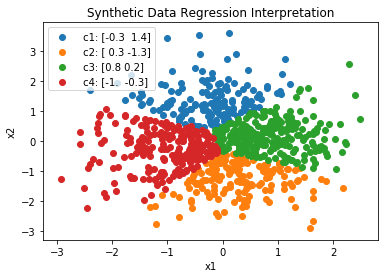

In [109]:
ind_sequence= model.sequence_indices
for i in range(1):
  a = ind_sequence[i]
  b = ind_sequence[i+1]  
  data  = model.Xs_transform[a:b] 
  for j in range(4):
        index_cluster = np.where(np.array(model.cluster_index[a:b])==j)[0]
        if(i==0):
          name = ' c' + str(j+1) + ': ' + str(np.round(model.cluster_centers[i][j],1))
        plt.scatter(data[index_cluster,0], data[index_cluster,1], label= name)
        plt.legend()
        plt.title("Synthetic Data Regression Interpretation")
        plt.xlabel('x1')
        plt.ylabel('x2')

## Linear model (Fidelity and MSE)

In [110]:
model_linear = linear_model.LinearRegression(fit_intercept=True) 
model_linear.fit(train, Y_train)
print ("Fidelity of the linear model is : " + str(np.mean((model_linear.predict(test)-Y_test)**2)))
print ("MSE of linear model is : " + str(np.mean((model_linear.predict(test)-labels_test)**2)))

Fidelity of the linear model is : 8.36560853260467
MSE of linear model is : 11.00161836563928


In [111]:
model_linear = linear_model.LinearRegression(fit_intercept=True) 
model_linear.fit(train, Y_train)
print("Linear model  R^2 Score: " +str(round(r2_score(model_linear.predict(test),Y_test),3)))
print ("Fidelity of the linear model is : " + str(np.mean((model_linear.predict(test)-Y_test)**2)))
print("Linear model  R^2 Score: " +str(round(r2_score(model_linear.predict(test),labels_test),3)))
print ("MSE of linear model is : " + str(np.mean((model_linear.predict(test)-labels_test)**2)))

Linear model  R^2 Score: -31.261
Fidelity of the linear model is : 8.36560853260467
Linear model  R^2 Score: -41.426
MSE of linear model is : 11.00161836563928


In [112]:
model_linear = linear_model.LinearRegression(fit_intercept=True) 
model_linear.fit(train, labels_train)
print("Linear model  R^2 Score: " +str(round(r2_score(model_linear.predict(test),Y_test),3)))
print ("Fidelity of the linear model is : " + str(np.mean((model_linear.predict(test)-Y_test)**2)))
print("Linear model  R^2 Score: " +str(round(r2_score(model_linear.predict(test),labels_test),3)))
print ("MSE of linear model is : " + str(np.mean((model_linear.predict(test)-labels_test)**2)))

Linear model  R^2 Score: -29.547
Fidelity of the linear model is : 8.346933806542802
Linear model  R^2 Score: -39.17
MSE of linear model is : 10.976289459803684


In [0]:
r2_score(labels_test, model_linear.predict(test))

0.002671097713220383

## Regression Tree (Fidelity and MSE)

In [113]:
model_tree = tree.DecisionTreeRegressor(max_leaf_nodes=4)
model_tree = model_tree.fit(train, Y_train)
print("Tree model  R^2 Score: " +str(round(r2_score(model_tree.predict(test),Y_test),3)))
print ("Fidelity of the regression tree model is : " + str(np.mean((model_tree.predict(test)-Y_test)**2)))
print("Tree model R^2 Score: " +str(round(r2_score(model_tree.predict(test),labels_test),3)))
print ("MSE of regression tree model is : " + str(np.mean((model_tree.predict(test)-labels_test)**2)))

Tree model  R^2 Score: -1.045
Fidelity of the regression tree model is : 5.095522171368624
Tree model R^2 Score: -1.9
MSE of regression tree model is : 7.224160658778164


In [114]:
model_tree = tree.DecisionTreeRegressor(max_leaf_nodes=4)
model_tree = model_tree.fit(train, labels_train)
print("Tree model  R^2 Score: " +str(round(r2_score(model_tree.predict(test),Y_test),3)))
print ("Fidelity of the regression tree model is : " + str(np.mean((model_tree.predict(test)-Y_test)**2)))
print("Tree model R^2 Score: " +str(round(r2_score(model_tree.predict(test),labels_test),3)))
print ("MSE of regression tree model is : " + str(np.mean((model_tree.predict(test)-labels_test)**2)))

Tree model  R^2 Score: -0.3
Fidelity of the regression tree model is : 4.709379362757954
Tree model R^2 Score: -0.807
MSE of regression tree model is : 6.544692585297059
